# homework 04: a plague of sand mice


## 1. test Moriarty's method yourself
After some prying on your part, Moriarty reluctantly discloses that his secret proprietary machine learning method is to score +1 for each A or T, and -1 for each C or G.

You note that Moriarty showed results for discriminating against random sequences (of uniform base composition), but the problem is to discriminate against sand mouse sequences.

Implement Moriarty's secret proprietary machine learning method. Test it on the sequences in pathogen.fa and sandmouse.fa. Make a plot of your own, showing a histogram and a ROC plot like in Moriarty's figure, but for performance in discriminating pathogen from sand mouse sequences, using matplotlib.

What do you conclude? Why are your results different from Moriarty's?

In [1]:
!tail -10 pathogen.fa

>pathogen.9996
TGAAAAATGGTATCATTTTGATTTGCATCAAGAAAGAGCTTCCAAATCATTCAATGTCATTTAATATTATCTTTTAAAAAAGAAACATAGAGGATATTTTGTAAAACATCTTATTTATGCTTTTAATCTTAACTTTCTTAGTCGAATATTTAAATTTTAATAATTTTTTTGCCATTTGTTTCAATTATTCTTAAATTACC
>pathogen.9997
AAAATATGGAGCTACAGGAAAAATTTGAAAATGAAATGGATGCTAAAATGAAAATTTTTGAAACTGGAATTTTTATCTAATAAGCATCTTTAAATCAACAGCGAAGATCAATAAATTATATGGATTTAAGCAATCGTTTATCTAAAGAGTTTTGAAATTGAGTTCTATAGGGACTTCTAACAATCAAAATACTATTTAAT
>pathogen.9998
TACAAAAAATATCTATGGATATTTTAATTTAATTCTGGTATGCTGAGGATAAATTCAATACACAACCTCCCATAAGAAAATTTATAATTTTATTTTCTTAGACAAGATCCCATTGTCAAATATTCCTAAATATAAATCAGAAAATTTTAATCAAATAAGCTAAGTAAATAAATAAAATTGTAATAATAAAATTTGTAGAT
>pathogen.9999
TATATTTTTTTATAGAAAATTATTTATTTGCAATTTCTTTAATTTTTGTATATTATTTGTAAAATAGTTTAAAATCTTCCTTTTTTAATAAGAAATATTTCGATATTCCCAATGTAAATGGAATTTGGGATGCAGACTGAGATATAATCTGGATCTAATTGGTATTATTGAAAAATAATTTATTTTATTTAGTTCTTAAT
>pathogen.10000
AAAGGAATCTGCTTAGCTAAGATATATGTTAATGTTTTGTTATATAGAATATAGAATCCTTTTTTTTAAAAAAATATGATTTGAATTTAAATTAATGCTTAAACTTTTAAGAGAAGGAAA

In [2]:
import numpy as np
import random
import itertools as it
%matplotlib inline
random.seed(1048)
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from tqdm import tqdm

class Moriarty_scorer:
    def __init__(self, seq=None):
        self.seqs = {}
        self.seqs["pathogen"] = self.read_seq_from_fasta("pathogen.fa")
        self.seqs["sandmouse"] = self.read_seq_from_fasta("sandmouse.fa")
        self.seq_len = len(self.seqs["pathogen"]) # same for the two
        self.roc = {"true positives" : [],
                    "false positives" : []}
        self.scores = {"pathogen":[],
                       "sandmouse":[],}
        self.cal_score()
        self.cal_roc()
        
    def read_seq_from_fasta(self, filepath):
        with open(filepath, "r") as file:
            return [line.rstrip("\n") for line in file.readlines() if line[0]!=">"]
    
    def read_score(self):
        if not self.scores:
            print("No score yet")
            return 
        for k,v in self.scores.items():
            print("%s score mean: %f"%(k, stat.mean(v)))
            print("%s score std: %f"%(k, stat.stdev(v)))
            print("---------------------------")
    
    def cal_score(self):
        print("Calculating score using the Moriarty method")
        for k,v in self.seqs.items():
            score_list = []
            for seq in v:
                score = 0
                for g in seq:
                    if g == "A" or g == "T":
                        score += 1
                    elif g == "G" or g=="C":
                        score -= 1  
                score_list.append(score)  
            self.scores[k] = score_list
        self.read_score()       
    
    def cal_roc(self):
        """Given the sequences, this function finds true and false positives
        >> A plot of sensitivity versus false positive rate (both from 0 to 1.0) for all possible choices of 
        >> threshold is called a receiver operating characteristic plot (ROC plot). The name "receiver operating 
        >> characteristic" is a historical artifact, as you might guess. It's military jargon that arose in WWII 
        >> for radar receivers distinguishing blips as enemy vs. friendly aircraft. Correct friend/foe classification 
        >> is a pretty important operating characteristic for a military radar receiver.A perfect ROC plot leaps
        >> immediately to 100% sensitivity at 0% FPR. Random guessing gives you a diagonal line.
        Quoted form course website: http://mcb112.org/w04/w04-lecture.html
        """
        thresholds = np.linspace(min((min(self.scores["pathogen"]), min(self.scores["sandmouse"]))), 
                                 max((max(self.scores["pathogen"]), max(self.scores["sandmouse"]))), 
                                 num=self.seq_len)
        
        print("Calculating ROC...")
        for threshold in tqdm(thresholds):
            tp = [1 if score >= threshold else 0 for score in self.scores["pathogen"]]
            fp = [1 if score >= threshold else 0 for score in self.scores["sandmouse"]]    
            self.roc["true positives"].append(sum(tp)/self.seq_len)
            self.roc["false positives"].append(sum(fp)/self.seq_len)
    
    def peak_seq(self, n=5):
        for k,v in self.seqs.items():
            print(">> "+k)
            print("---------------------------")
            print("\n\n".join(v[:n]))
            
    def visualize_scores(self, output_filename=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
        sns.set_style("white")

        bins = np.linspace(min((min(self.scores["pathogen"]), min(self.scores["sandmouse"]))), 
                           max((max(self.scores["pathogen"]), max(self.scores["sandmouse"]))), 
                           50)
        ax1.hist(self.scores["pathogen"], bins=bins, color = "orange", label="pathogen", alpha = 1, density=True)
        ax1.hist(self.scores["sandmouse"], bins=bins, color = "black", label="sandmouse", alpha=0.3, density=True)

        ax1.set_title("score histogram")
        ax1.set_xlabel("Score")
        ax1.set_ylabel("frequency")
        ax1.legend()
        
        ax2.plot(self.roc["false positives"], self.roc["true positives"])
        ax2.set_title("ROC plot")
        ax2.set_xlabel("false positives")
        ax2.set_ylabel("true positives")
        if output_filename:
            plt.savefig(output_filename, format="png")
        plt.show()
        
    

In [3]:
moriarty_scorer = Moriarty_scorer()

Calculating score using the Moriarty method
pathogen score mean: 109.894600
pathogen score std: 12.794439
---------------------------
sandmouse score mean: 110.174600
sandmouse score std: 11.688575
---------------------------
Calculating ROC...


100%|██████████| 10000/10000 [00:33<00:00, 296.70it/s]


In [4]:
## let's check if it read in the seqs properly
moriarty_scorer.peak_seq(n=2)

>> pathogen
---------------------------
TTTTATAGCTTAAATTAATCTTGCAATAATACAATGGTGCTCCAATTATCATAAGAAAATACTTTAAGAAATAGAATTATCTATAGAGTCCTTATCTGTCTTGTTTATATGAGACAGTTAATTTGAAGAAGGAATAATCTTTCCGTTTTTAGATATTAAAATAATTATACCTCATTAAAGTTTTCAGATAATTTCTAGAA

ATTTATGAAAGATTTTTTCTATTTTTTATAGATGTCTATTCTGTGAATTTTCAATAAACGATTTTAGTACAAAGTATATAACTGCACATGCTGTAGATGTATTAAAAAAATTCTAACAGATTAAGAAGATTAAAATGGAAATGTTCTCCGAAATGTTGGAAACATAGAAATTAAAACTATTTATAAGGTTAAAGCTGTTT
>> sandmouse
---------------------------
GATAAATAACACATTTTTCTATATATCATTATTTGTTATATGATTATAATATAATTATTTAAAAACTAGAATTTGCAAATGCATATATATGTGAAATTTTATATTAATTAAGTATGAAAAATGGAGTAGAATAAAAAATTAATATAAATTAATTAAAACAAAGTACAGATAAATCTATGTAAATTATCATAAAATATGGA

TGGTTAAACAGTTTCGAAATTAGTAAGTAAAGTGAAGTGTATATAGAATGAGTATTTTAAAAATCATAACTAAGAACTGTAAATACTATATATTATAATAACCAACTACTTATTAATTATTAATTTTTTAAATTTTGTAAAATTAGTCAATTTGTTAATTATTAATATCGGTAAATGCTCATGCTTTAGACATGCTATAA


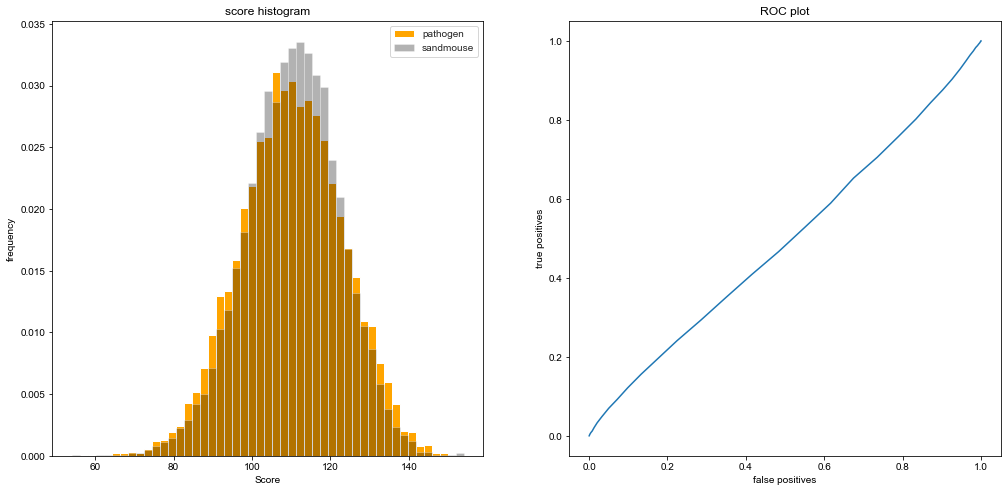

In [5]:
moriarty_scorer.visualize_scores()

This is just, very obvious to see, that the pathogen and the sandmouse sequences had almost the same distribution using Moriarty's methods. The ROC plot almost shows a straight diagnal line, showing that Moriarty's secret proprietary machine learning method is no better than random guessing. 

Why didn't Moriarty's native "A/T + 1; C/G -1" loss function work out? The answer might be that the four bases A, C, T, G are not uniformly distributed in both the sandmouse's DNA sequences and those of the pathogen, while M's loss function assume a uniform distribution of them (So he just calculated the pathogen's difference to 10,000 random sequences of uniform base composition).

## 2. make your own method
You think you can do better, using higher order Markov models.

- Implement a **second order Markov model** (i.e. with parameters $P(x_i|x_i−1,x_i−2)$. )

- Train (i.e. estimate parameters for) two models: one on pathogen.fa, and one on sandmouse.fa.

- Implement a routine that calculate the log-odds score for a sequence read, given the read sequence and the two 2nd-order Markov models.

- Plot the histogram and ROC plot for your 2nd-order Markov model method, for results of discriminating the reads in pathogen.fa from sandmouse.fa.

Because you're estimating the parameters of your models from the example data, you should train and test on separate data sets. Use half of each sequence set for training, and half for testing.

In [6]:
import random as rand
import itertools as it

rand.seed(1028)

bases = ["A", "C", "T", "G"]

# Let me continue using class here, I'm not very good at it, so trying to improve
class Sequence:
    def __init__(self):
        self.sample_size = None
        self.test = []
        self.train = []
        self.prob_dict = {}
        ## since we are using a second order Markov chain, we skipped the first 2 bases
        ## So dor each 2mer we calc a probability of it appearing at the first position
        self.start_position_dict = {}
        
    def read_data_as_sample(self, filepath):
        with open(filepath, "r") as file:
            sample = [line.rstrip("\n") for line in file.readlines() if line[0]!=">"]
        self.sample_size = len(sample)
        print("%i samples read, splitting into train test sets..."%self.sample_size)
        self.train_test_split(sample)

    def train_test_split(self, sample, test_size=0.5):
        n_test = int(self.sample_size*test_size)
        self.test = rand.sample(sample, n_test)
        self.train = [s for s in sample if s not in self.test]
        print("%i training sample generated\n%i test sample generated"%(len(self.train), len(self.test)))    

    def create_frequency_dict(self):
        print("Creating 3-mer probability dictionary...")
        ## create a dictionary of occurences of all posible 3-mers of ACTG
        d_3mer = dict.fromkeys(["".join(i) for i in list(it.product("AGTC", repeat=3))], 0)
        
        ## loop through all 3-mers to create a occurence dict
        for seq in tqdm(self.train):
            for i in range(2,len(seq)-2):
                d_3mer[seq[i:i+3]] += 1
        ## Now our dictinary looks like {3-mer: count}, 
        ## now let's turn it into {2-mer : {'A':count,
        ##                                  'C':count, ...}}
        
        # initialize our 2-mer dict
        d_2mer = dict.fromkeys(["".join(i) for i in list(it.product("AGTC", repeat=2))], 
                               dict.fromkeys(bases,0))
        
        keys = list(d_3mer.keys())
        values = np.array(list(d_3mer.values()))
        values.shape = [int(len(d_3mer)/4), 4]
        
        ## create a new value list for normalized values (probability)
        normalized_values = []
        for k2mer in values:
            k2mer = k2mer/sum(k2mer)
            for base_prob in k2mer:
                normalized_values.append(base_prob)
        
        d_3mer = dict(zip(keys, normalized_values))
        
# --------Not sure why this didn't work out -------------------            
#         # loop through the 3-mer dict to update probs. k3mer[:2] is the first 2 bases of the 3mer and [k3mer[:-1] is the last base
#         for k3mer, count in d_3mer.items():
#             print("[%s][%s]"%(k3mer[:2],k3mer[-1:]))
#             print(count)
            
#             d_2mer[k3mer[:2]][k3mer[-1:]] = count 
        
#         print(d_2mer)
#         ## now for each 2-mer dict, normalize the count distribution to find a probablit distribution that adds up to 1 
#         for k2mer, distribution in d_2mer.items():
#             normalization_factor=1/sum(distribution.values())
#             d_2mer[k2mer] = {base: count*normalization_factor for base, count in distribution.items()}
        
#         ##  update d_3mer with the probabilities
#         for k2mer, distribution in d_2mer.items():
#             for base, probability in distribution.items():
#                 d_3mer[k2mer+base] = probability
        self.prob_dict = d_3mer
        
       
    
    def create_first2_freq_dict(self):
        d_2mer = dict.fromkeys(["".join(i) for i in list(it.product("AGTC", repeat=2))], 0)
        
        ## loop through all 3-mers to create a occurence dict
        for seq in tqdm(self.train):
            d_2mer[seq[:2]] += 1
        ## now normalize the dictionary to make all the values add up to 1 
        normalization_factor=1/sum(d_2mer.values())
        d_2mer = {k : v*normalization_factor for k,v in d_2mer.items()}
        self.start_position_dict = d_2mer
        

### Let's create a model for the pythogen sequences

In [7]:
pathogen = Sequence()
pathogen.read_data_as_sample("pathogen.fa")

10000 samples read, splitting into train test sets...
5000 training sample generated
5000 test sample generated


In [8]:
pathogen.create_frequency_dict()
pathogen.create_first2_freq_dict()

Creating 3-mer probability dictionary...


100%|██████████| 5000/5000 [00:00<00:00, 2521221.45it/s]


In [9]:
pathogen.prob_dict


{'AAA': 0.4807825865006203,
 'AAG': 0.09151347148106158,
 'AAT': 0.35300682032682956,
 'AAC': 0.07469712169148854,
 'AGA': 0.447267292912041,
 'AGG': 0.1513663535439795,
 'AGT': 0.22990796090710694,
 'AGC': 0.17145839263687257,
 'ATA': 0.3576739603490194,
 'ATG': 0.1067684521657771,
 'ATT': 0.4200636513775774,
 'ATC': 0.11549393610762612,
 'ACA': 0.4308125364731729,
 'ACG': 0.09052212419759019,
 'ACT': 0.3272802169510144,
 'ACC': 0.15138512237822252,
 'GAA': 0.44454665799098025,
 'GAG': 0.12174381296416792,
 'GAT': 0.3627633556956629,
 'GAC': 0.0709461733491889,
 'GGA': 0.5536888643271622,
 'GGG': 0.10472506217187068,
 'GGT': 0.2326609560652114,
 'GGC': 0.10892511743575574,
 'GTA': 0.36655813464972165,
 'GTG': 0.09774883590659245,
 'GTT': 0.4274060847950145,
 'GTC': 0.10828694464867136,
 'GCA': 0.42066200769272444,
 'GCG': 0.07833577116853567,
 'GCT': 0.39471260631670185,
 'GCC': 0.10628961482203803,
 'TAA': 0.4016196209159732,
 'TAG': 0.11584366581128938,
 'TAT': 0.399141425042569,
 '

### Now another one for the sandmouse frequencies

In [10]:
sandmouse = Sequence()
sandmouse.read_data_as_sample("sandmouse.fa")
sandmouse.create_frequency_dict()
sandmouse.create_first2_freq_dict()
sandmouse.prob_dict


10000 samples read, splitting into train test sets...
5000 training sample generated
5000 test sample generated
Creating 3-mer probability dictionary...


100%|██████████| 5000/5000 [00:00<00:00, 2642913.67it/s]


{'AAA': 0.3863543815832338,
 'AAG': 0.11325876859593875,
 'AAT': 0.3872706048430883,
 'AAC': 0.11311624497773917,
 'AGA': 0.38546451673385207,
 'AGG': 0.10956688853473329,
 'AGT': 0.3896596981344333,
 'AGC': 0.11530889659698135,
 'ATA': 0.3895554847932574,
 'ATG': 0.11390998584001247,
 'ATT': 0.38440639841733343,
 'ATC': 0.11212813094939668,
 'ACA': 0.3908735271381386,
 'ACG': 0.11054369978214529,
 'ACT': 0.3868912366183326,
 'ACC': 0.1116915364613835,
 'GAA': 0.3919409601056305,
 'GAG': 0.11147788361784401,
 'GAT': 0.38505611619353014,
 'GAC': 0.11152504008299538,
 'GGA': 0.3958333333333333,
 'GGG': 0.11061507936507936,
 'GGT': 0.3826058201058201,
 'GGC': 0.1109457671957672,
 'GTA': 0.3876095850379895,
 'GTG': 0.11237872589129164,
 'GTT': 0.3874693161893629,
 'GTC': 0.11254237288135593,
 'GCA': 0.3929292113972072,
 'GCG': 0.11001695052062313,
 'GCT': 0.38477681814512876,
 'GCC': 0.11227701993704092,
 'TAA': 0.38870647810280745,
 'TAG': 0.1115203130394752,
 'TAT': 0.387413430097554,
 '

In [11]:
def get_log_likelihood(seqs, model):
    """Calculate the loglikelyhood ratio for each of the seq in the test set"""
    log_likelihood = []
    for seq in tqdm(seqs):
        prob = [np.log10(model.start_position_dict[seq[:2]])]
        for i in range(2,len(seq)-2):
            prob.append(np.log10(model.prob_dict[seq[i:i+3]]))
        log_likelihood.append(sum(prob))
    return log_likelihood

In [12]:
## Get the ratios
pathogen_llh_1 = get_log_likelihood(pathogen.test, pathogen)        
pathogen_llh_2 = get_log_likelihood(pathogen.test, sandmouse)        
pathogen_ratios = [llh1 - llh2 for llh1, llh2 in zip(pathogen_llh_1, pathogen_llh_2)]

## Same as pathogen, in one line
sandmouse_ratios = [llh1 - llh2 for llh1, llh2 in zip(get_log_likelihood(sandmouse.test, pathogen), 
                                                      get_log_likelihood(sandmouse.test, sandmouse))]

100%|██████████| 5000/5000 [00:01<00:00, 4495.95it/s]


In [13]:
## These are the same as in Q1, just with variable names changed

tps = []
fps = []
thresholds = np.linspace(min(pathogen_ratios + sandmouse_ratios), max(pathogen_ratios + sandmouse_ratios), 
                         num=len(pathogen_ratios))

print("Calculating ROC...")
for threshold in tqdm(thresholds):
    tp = [1 if score >= threshold else 0 for score in pathogen_ratios]
    fp = [1 if score >= threshold else 0 for score in sandmouse_ratios]    
    tps.append(sum(tp)/len(pathogen_ratios))
    fps.append(sum(fp)/len(sandmouse_ratios))


def visualize_scores(tps, fps, output_filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
    sns.set_style("white")

    bins = np.linspace(min(pathogen_ratios + sandmouse_ratios), max(pathogen_ratios + sandmouse_ratios), 60)
    ax1.hist(pathogen_ratios, bins=bins, color = "orange", label="pathogen", alpha = 1, density=True)
    ax1.hist(sandmouse_ratios, bins=bins, color = "black", label="sandmouse", alpha=0.3, density=True)

    ax1.set_title("score histogram")
    ax1.set_xlabel("score")
    ax1.set_ylabel("frequency")
    ax1.legend()

    ax2.plot(fps, tps)
    ax2.set_title("ROC plot")
    ax2.set_xlabel("false positives")
    ax2.set_ylabel("true positives")
    if output_filename:
        plt.savefig(output_filename, format="png")
    plt.show()

Calculating ROC...


100%|██████████| 5000/5000 [00:02<00:00, 1716.38it/s]


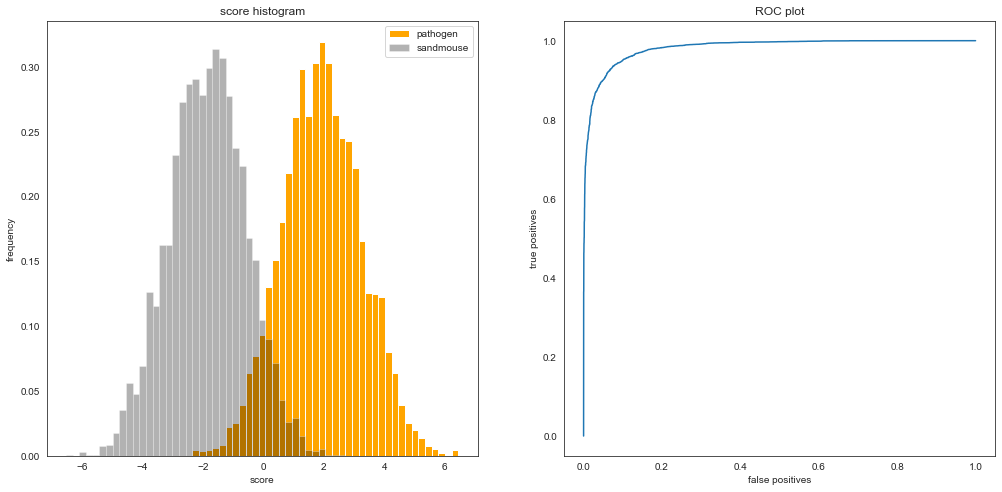

In [14]:
visualize_scores(tps, fps, "markoc_roc.png")


In [15]:
## calculate how apart the two distributions are 
round((stat.mean(pathogen_ratios)-stat.mean(sandmouse_ratios))/stat.stdev(sandmouse_ratios),2)



2.99

Seems to be working. Nice ROC plot showing high TPs comparing to FPs. Also the log-likelihood distribution of the pathogen ad that of the sand mouth have different means ( > 2.5 standard deviations (of sandmouse) away), as shown in previous 2 chunks.

## 3. how good is your method?
Suppose the lab needs to achieve 90% sensitivity (i.e. detecting 90% of pathogen sequences).

- What score threshold would you need to set?

- What is your estimate for the false positive rate at that threshold?

Remember that in an RNA-seq sample from an infected sand mouse, 1% of the reads are from the pathogen, and 99% of the reads are from the mouse. Using your estimates above, if you use your method to classify reads, what proportion of the reads that you label as "pathogen" are actually false positives from the sand mouse? (This is your false discovery rate, FDR.)

(Use Python code to answer these questions, using the results of your testing above.)

In [16]:
## find the indices of those thresholds with qualified sensitivities
qualified = [i for i, sensitivity in enumerate(tps) if sensitivity >= 0.9] 
index = max(qualified)  ## set it to the last index, meaning the one with lowest feasible sensitivity

print("Threshold to set: %s, with a sensitivity of %f " % (thresholds[index], tps[index]))
print("False postive rate estimate at threshold %i: %f" % (thresholds[index], fps[index]))



Threshold to set: 0.23941328684745855, with a sensitivity of 0.900000 
False postive rate estimate at threshold 0: 0.050000


$$\begin{aligned}
FDR &= \frac{FP}{FP + TP}\\\\
&= \frac{FP*0.99}{FP*0.99 + TP*0.1}\\\\
&= \frac{0.05*0.99}{0.05*0.99 + 0.90*0.01}\\\\
&= 0.846
\end{aligned}$$



So the False Discover Rate is 0.846.